In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis import load_sim_states, load_toml, get_vehicle_arrival_and_exits, display_and_save_animation
from tqdm import tqdm
from IPython.display import HTML

### Set-up config files and run with single seed

In [2]:
# Seed
SEED = 0

# File names for two crossings
config_file2 = "zebra_config_2crossings.toml"
outfile2 = "sim_states_2crossings.json"

# File names for three crossings
config_file3 = "zebra_config_3crossings.toml"
outfile3 = "sim_states_3crossings.json"

In [3]:
%%writefile $config_file2
road_length = 600
zebra_crossings = [180, 440]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting zebra_config_2crossings.toml


In [4]:
%%writefile $config_file3
road_length = 600
zebra_crossings = [180, 300, 440]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting zebra_config_3crossings.toml


In [5]:
%%capture
# Run the simulations
!cargo run -- --config_file $config_file2 --outfile $outfile2 --seed $SEED
!cargo run -- --config_file $config_file3 --outfile $outfile3 --seed $SEED

In [6]:
# Load zebra toml and outfiles
zebra_toml2 = load_toml(config_file2)
states2 = load_sim_states(outfile2)
zebra_toml3 = load_toml(config_file3)
states3 = load_sim_states(outfile3)

In [7]:
# Get dataframes for two and three crossing versions
df2 = get_vehicle_arrival_and_exits(states2)
df3 = get_vehicle_arrival_and_exits(states3)

> Mean transit times:
Two crossings:   54.603s
Three crossings: 53.838s
> Median transit times:
Two crossings:   53.113s
Three crossings: 52.647s


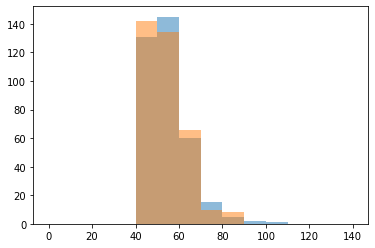

In [8]:
# Plot hists, compare means and medians
bins = np.arange(0, 150, 10)
alpha = 0.5
plt.hist(df2["transit"], bins=bins, alpha=alpha)
plt.hist(df3["transit"], bins=bins, alpha=alpha)
mean2, median2 = df2["transit"].mean(), df2["transit"].median()
mean3, median3 = df3["transit"].mean(), df3["transit"].median()
print(f"> Mean transit times:")
print(f"Two crossings:   {mean2:.3f}s")
print(f"Three crossings: {mean3:.3f}s")
print(f"> Median transit times:")
print(f"Two crossings:   {median2:.3f}s")
print(f"Three crossings: {median3:.3f}s")

In [9]:
# Display and save animation
html = display_and_save_animation(states3, zebra_toml3, "test.gif", frame_limit=10000, write=False)

display(HTML(html))
plt.close()

### Set-up and get averages across multiple runs

In [10]:
%%capture

# Number of simulations to aggregate
N_SEEDS = 50

# 2 crossings
means2, medians2 = [], []
for i in tqdm(range(N_SEEDS)):
    !cargo run -- --config_file $config_file2 --outfile $outfile2 --seed $i
    zebra_toml2 = load_toml(config_file2)
    states2 = load_sim_states(outfile2)
    df2 = get_vehicle_arrival_and_exits(states2)
    means2.append(df2["transit"].mean())
    medians2.append(df2["transit"].median())

In [11]:
%%capture

# 3 crossings
means3, medians3 = [], []
for i in tqdm(range(N_SEEDS)):
    !cargo run -- --config_file $config_file3 --outfile $outfile3 --seed $i
    zebra_toml3 = load_toml(config_file3)
    states3 = load_sim_states(outfile3)
    df3 = get_vehicle_arrival_and_exits(states3)
    means3.append(df3["transit"].mean())
    medians3.append(df3["transit"].median())

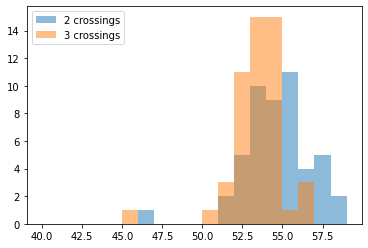

In [22]:
# Compare means
bins = np.arange(40, 60, 1)
plt.hist(means2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(means3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.show()

In [30]:
from scipy.stats import ttest_ind, mannwhitneyu

print(f"Difference in mean of means: {np.mean(means2)-np.mean(means3):.3f}s")
ttest_ind(means2, means3)

Difference in mean of means: 1.264s


Ttest_indResult(statistic=3.2085552083171103, pvalue=0.0018031959406969605)

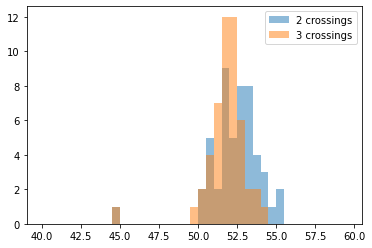

In [31]:
# Compare medians
bins = np.arange(40, 60, 0.5)
plt.hist(medians2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(medians3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.show()

In [32]:
from scipy.stats import ttest_ind, mannwhitneyu

print(f"Difference in mean of medians: {np.mean(medians2)-np.mean(medians3):.3f}s")
mannwhitneyu(medians2, medians3)

Difference in mean of medians: 0.585s


MannwhitneyuResult(statistic=1615.5, pvalue=0.011861040785418785)